<a href="https://colab.research.google.com/github/radrams/child_malnutrition/blob/master/Wasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import random
import warnings
from math import nan

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import xgboost
import scipy.stats as stats
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, ParameterGrid
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
import statsmodels.api as sm
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

path = 'https://github.com/radrams/child_malnutrition/raw/master/data/wasting.xlsx'
############## Read from Excel file ######################################################
# Read the data
df_immu_hyg_wasting = pd.read_excel(path, sheet_name='wasting')
# Print Column names
print(df_immu_hyg_wasting.head())
print('===============================================================')
# print(df_immu_hyg_wasting.columns.ravel())
print(df_immu_hyg_wasting.describe())
print('===============================================================')
print(df_immu_hyg_wasting.isnull().sum())
print('===============================================================')

   SH.H2O.BASW.ZS  SH.IMM.HEPB  SH.IMM.HIB3  SH.IMM.IBCG  SH.IMM.IDPT  SH.IMM.MEAS  SH.IMM.POL3  SH.STA.ARIC.ZS  SH.STA.BASS.ZS  SH.STA.HYGN.ZS  SH.STA.ORCF.ZS  SH.STA.ORTH  SH.STA.WAST.ZS
0       52.347633          NaN          NaN         81.0         59.0         65.0         62.0            37.0        9.963399             NaN            59.2         17.8            17.1
1       59.891152          NaN          NaN         87.0         82.0         79.0         82.0            54.3       23.394743             NaN            49.9          NaN             8.5
2       64.416401         91.0          NaN         98.0         91.0         89.0         91.0             NaN       31.831055       65.243300             NaN          NaN             9.1
3       67.551234         91.0         86.0         95.0         90.0         90.0         90.0             NaN       37.820551       65.322480            48.0          NaN            11.0
4       73.816151         91.0         91.0         98.

In [18]:
############ Drop Columns having 'na' count greater than 150 rows =================
max_number_of_nas = 150
df_immu_hyg_wasting = df_immu_hyg_wasting.loc[:, (df_immu_hyg_wasting.isnull().sum(axis=0) <= max_number_of_nas)]
############################################### MISSING VALUES #############6############################################
# Number of missing values
print('===================== Missing Values Summary Before Imputation=====================')
print(df_immu_hyg_wasting.isnull().sum())
print('===============================================================')

############################################### Handling missing values using mean imputation
df_immu_hyg_wasting.fillna(df_immu_hyg_wasting.mean(), inplace=True)
print('===================== Missing Values Summary After Imputation=====================')
print(df_immu_hyg_wasting.isnull().sum())
print('===============================================================')

===================== Missing Values Summary Before Imputation=====================
SH.H2O.BASW.ZS     29
SH.IMM.HEPB        72
SH.IMM.HIB3       143
SH.IMM.IBCG        12
SH.IMM.IDPT        12
SH.IMM.MEAS        12
SH.IMM.POL3        12
SH.STA.BASS.ZS     30
SH.STA.WAST.ZS      0
dtype: int64
===================== Missing Values Summary After Imputation=====================
SH.H2O.BASW.ZS    0
SH.IMM.HEPB       0
SH.IMM.HIB3       0
SH.IMM.IBCG       0
SH.IMM.IDPT       0
SH.IMM.MEAS       0
SH.IMM.POL3       0
SH.STA.BASS.ZS    0
SH.STA.WAST.ZS    0
dtype: int64


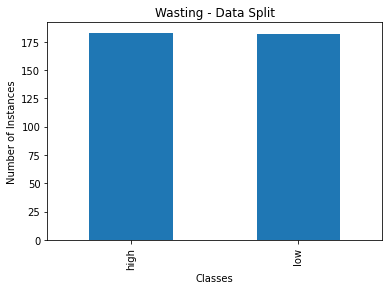

In [19]:
########################################### Defining input and output columns
X = df_immu_hyg_wasting.loc[:, df_immu_hyg_wasting.columns != 'SH.STA.WAST.ZS']

################# Grouping Data
median_split = df_immu_hyg_wasting['SH.STA.WAST.ZS'].median()
y = pd.cut(df_immu_hyg_wasting['SH.STA.WAST.ZS'], bins=[0, median_split, 100], right=False, labels=['low', 'high'])
y.value_counts().plot(kind='bar')
plt.title("Wasting - Data Split")
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.show()

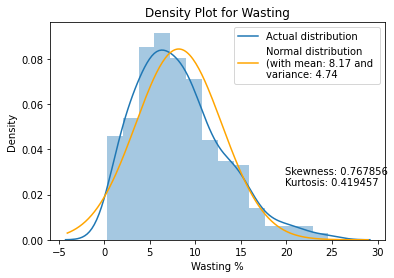

In [20]:
###################################################################################################
############################################## Distribution plot
f, ax = plt.subplots(1, sharex=True)
mean_value = df_immu_hyg_wasting['SH.STA.WAST.ZS'].mean()
std_value = df_immu_hyg_wasting['SH.STA.WAST.ZS'].std()
sns.distplot(df_immu_hyg_wasting['SH.STA.WAST.ZS'], kde_kws={"label": "Actual distribution"},
             fit=stats.norm, fit_kws={"label": "Normal distribution\n(with mean: {:0.2f} and \nvariance: {:0.2f}"
                                               .format(mean_value, std_value), "color":"orange"})
plt.title('Density Plot for Wasting')
plt.xlabel('Wasting %')
plt.ylabel('Density')
plt.legend(loc="upper right")
f.text(x=0.7, y=0.3,  transform = ax.transAxes, s="Skewness: {:0.6f}".format(df_immu_hyg_wasting['SH.STA.WAST.ZS'].skew()))
f.text(x=0.7, y=0.25, transform = ax.transAxes, s="Kurtosis: {:0.6f}".format(df_immu_hyg_wasting['SH.STA.WAST.ZS'].kurt()))
plt.show()

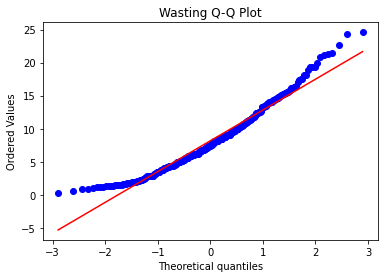

In [21]:
############ Q-Q Plot
stats.probplot(df_immu_hyg_wasting['SH.STA.WAST.ZS'], dist="norm", plot=plt)
plt.title("Wasting Q-Q Plot")
plt.show()

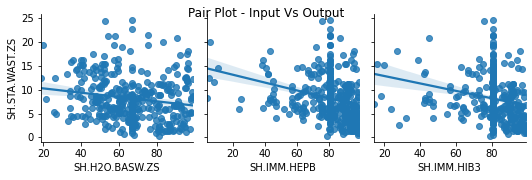

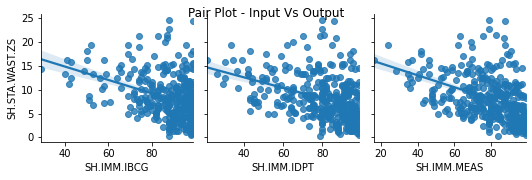

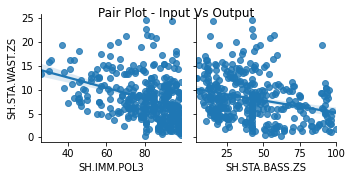

In [22]:
########### Pairplot
g = sns.pairplot(df_immu_hyg_wasting, x_vars=X.columns[0:3], y_vars='SH.STA.WAST.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()
g = sns.pairplot(df_immu_hyg_wasting, x_vars=X.columns[3:6], y_vars='SH.STA.WAST.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()
g = sns.pairplot(df_immu_hyg_wasting, x_vars=X.columns[6:9], y_vars='SH.STA.WAST.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()

SH.STA.WAST.ZS    1.000000
SH.H2O.BASW.ZS   -0.171591
SH.IMM.HIB3      -0.233937
SH.STA.BASS.ZS   -0.270880
SH.IMM.HEPB      -0.287594
SH.IMM.POL3      -0.366616
SH.IMM.IBCG      -0.376991
SH.IMM.IDPT      -0.390333
SH.IMM.MEAS      -0.430977
Name: SH.STA.WAST.ZS, dtype: float64


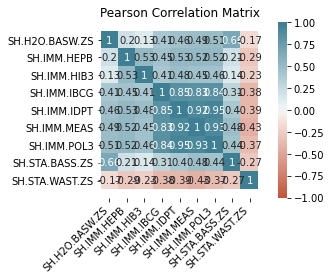

Removed Correlated Columns: {'SH.IMM.MEAS', 'SH.IMM.POL3', 'SH.IMM.IDPT'}


In [23]:
######################## Remove correlated Features
correlated_features = set()
corr = df_immu_hyg_wasting.corr()
print(corr['SH.STA.WAST.ZS'].sort_values(ascending=False))
print('===============================================================')
ax = sns.heatmap(
    corr,
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('Pearson Correlation Matrix')
# plt.tight_layout()
plt.show()

for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.add(colname)
print('Removed Correlated Columns:', correlated_features)
print('===============================================================')
X.drop(labels=correlated_features, axis=1, inplace=True)
#######################################################################################################
########################################################################################################

Average accuracy of GaussianNB is 0.5840090090090091
[0.43243243 0.59459459 0.64864865 0.59459459 0.48648649 0.63888889
 0.55555556 0.66666667 0.63888889 0.58333333]
Accuracy of the current fold:  0.5835616438356165
Average accuracy of SVC is 0.5485735735735735
[0.45945946 0.54054054 0.64864865 0.51351351 0.35135135 0.63888889
 0.52777778 0.61111111 0.58333333 0.61111111]
Accuracy of the current fold:  0.547945205479452
Average accuracy of DecisionTreeClassifier is 0.5459459459459459
[0.45945946 0.54054054 0.56756757 0.40540541 0.48648649 0.61111111
 0.55555556 0.69444444 0.47222222 0.66666667]
Accuracy of the current fold:  0.5397260273972603
Average accuracy of KNeighborsClassifier is 0.49887387387387383
[0.54054054 0.56756757 0.45945946 0.45945946 0.37837838 0.61111111
 0.52777778 0.55555556 0.33333333 0.55555556]
Accuracy of the current fold:  0.4986301369863014
Average accuracy of LogisticRegression is 0.6033033033033033
[0.59459459 0.51351351 0.64864865 0.64864865 0.40540541 0.63

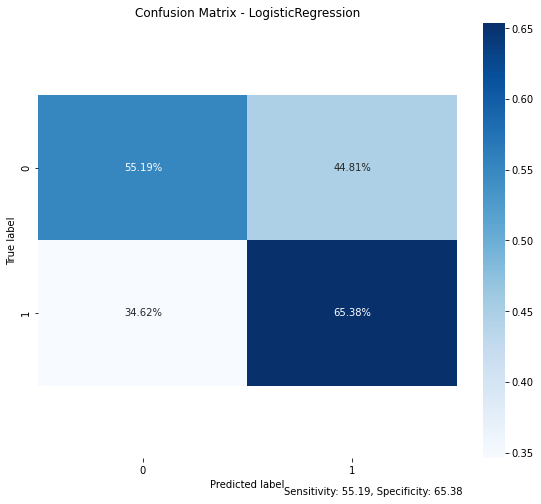

              precision    recall  f1-score   support

        high       0.62      0.55      0.58       183
         low       0.59      0.65      0.62       182

    accuracy                           0.60       365
   macro avg       0.60      0.60      0.60       365
weighted avg       0.60      0.60      0.60       365

Confusion matrix for  XGBClassifier :  [[126  57]
 [ 86  96]]
Sensitivity :  68.85245901639344
Specificity :  52.74725274725275


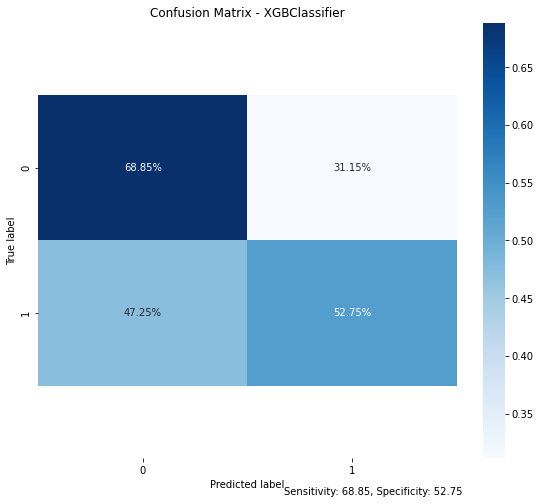

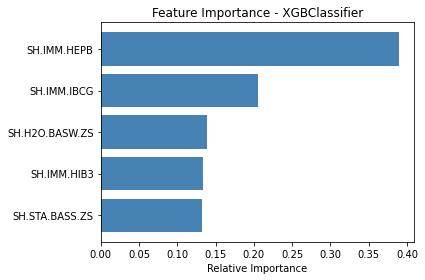

              precision    recall  f1-score   support

        high       0.59      0.69      0.64       183
         low       0.63      0.53      0.57       182

    accuracy                           0.61       365
   macro avg       0.61      0.61      0.61       365
weighted avg       0.61      0.61      0.61       365

Confusion matrix for  RandomForestClassifier :  [[113  70]
 [ 76 106]]
Sensitivity :  61.74863387978142
Specificity :  58.24175824175825


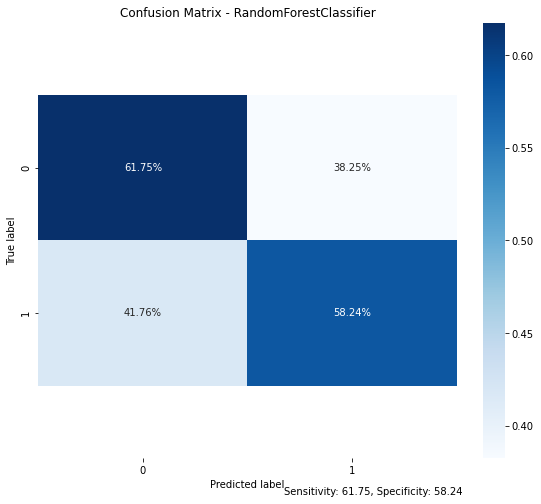

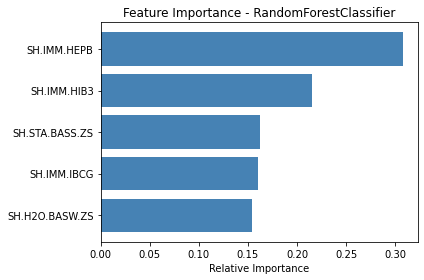

              precision    recall  f1-score   support

        high       0.60      0.62      0.61       183
         low       0.60      0.58      0.59       182

    accuracy                           0.60       365
   macro avg       0.60      0.60      0.60       365
weighted avg       0.60      0.60      0.60       365



In [24]:

########################################################################################################################################
##################### MODELS ######################
classifiers =[]
clf_nb = GaussianNB()
classifiers.append(clf_nb)
clf_svm = sklearn.svm.SVC()
classifiers.append(clf_svm)
clf_dt = sklearn.tree.DecisionTreeClassifier()
classifiers.append(clf_dt)
clf_knn = KNeighborsClassifier(n_neighbors=13)
classifiers.append(clf_knn)

clf_accuracies = {}
################################## Fine-tune Logistic Regression
# # define models and parameters
# model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X, y)
# print(grid_search.best_estimator_)
# classifiers.append(grid_search.best_estimator_)

################# Logistic Regression with fine-tuned parameters
classifiers.append(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False))

# ############## Fine-tune XGB #################
# estimator = xgboost.XGBClassifier(
#     nthread=4,
#     seed=42
# )
# parameters = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05],
# }

# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=parameters,
#     n_jobs = 10,
#     cv = 10,
#     verbose=True
# )
# grid_search.fit(X, y)
# print(grid_search.best_estimator_)
# classifiers.append(grid_search.best_estimator_)

################# XGB classifier with fine-tuned parameters
classifiers.append(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1))

# # ############################################### Fine-Tune Random Forest
# model = RandomForestClassifier()
# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10]
#
# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,
#               min_samples_split = min_samples_split,
#              min_samples_leaf = min_samples_leaf)
#
# gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, n_jobs = -1)
# bestF = gridF.fit(X, y)
# print(gridF.best_estimator_)
# classifiers.append(gridF.best_estimator_)

################# Random Forest classifier with fine-tuned parameters
classifiers.append(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False))

# ############### Function to plot confusion matrix
def plot_cm(model_name, df_cm):
    plt.figure(figsize = (8,7))
    sns.heatmap(df_cm/ df_cm.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues')
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) * 100
    print('Sensitivity : ', sensitivity)
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) * 100
    print('Specificity : ', specificity)
    plt.title('Confusion Matrix - ' + model_name)
    plt.figtext(0.5, 0.01, 'Sensitivity: {:.2f}, Specificity: {:.2f}'.format(sensitivity, specificity))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

############ Plot Feature Importance
def plot_feature_importance(model):
    try:
        model.fit(X, y)
        importance = model.feature_importances_
        features = X.columns
        indices = np.argsort(importance)
        plt.title('Feature Importance - ' + model.__class__.__name__)
        plt.barh(range(len(indices)), importance[indices], color='steelblue', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        pass

#############################################################
# Calculate cross-validation scores
for clf in classifiers:
    all_accuracies = cross_val_score(estimator=clf, X=X, y=y, cv=10)
    print("Average accuracy of %s is %s"%(clf.__class__.__name__, all_accuracies.mean()))
    print(all_accuracies)
    y_pred = cross_val_predict(clf, X, y, cv=10)
    accuracy = accuracy_score(y, y_pred)
    print('Accuracy of the current fold: ', accuracy )
    clf_accuracies[clf.__class__.__name__] = accuracy
    print('===============================================================')

# print the sorted classifier accuracies
sorted_accuracies = sorted(clf_accuracies.items(), key=lambda item: item[1], reverse=True)
print('Sorted Accuracies:')
print('===============================================================')
for k, v in sorted_accuracies:
    print(k, " ", v)

print('===============================================================')
top_3_accuracies = dict(sorted_accuracies[:3])

#### Calculate Confusion matrix and Feature Importance for Top 3 classifiers
for clf in classifiers:
    if clf.__class__.__name__ in top_3_accuracies.keys():
        y_pred = cross_val_predict(clf, X, y, cv=10)
        cm = confusion_matrix(y, y_pred)
        print('Confusion matrix for ', clf.__class__.__name__ , ': ', cm)
        plot_cm(clf.__class__.__name__, cm)
        plot_feature_importance(clf)
        print(classification_report(y, y_pred))
        print('===============================================================')

Area under the ROC curve for Logisitic Regression: 0.646895
Area under the ROC curve for GaussianNB: 0.632003
Area under the ROC curve for XGB Classifier: 0.589939


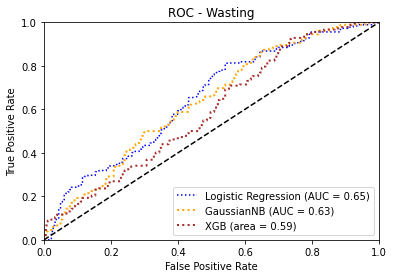

In [25]:
####################### Compute ROC curve and area the curve
## ROC Curve for Logisitic Regression
probas_ = cross_val_predict(LogisticRegression(), X, y, cv=10, method="predict_proba")
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y, probas_[:, 1], pos_label='low')
roc_auc_svc = auc(fpr_svc, tpr_svc)
print("Area under the ROC curve for Logisitic Regression: %f" % roc_auc_svc)

# Plot ROC curve
plt.clf()
plt.plot(fpr_svc, tpr_svc, "b:", label='Logistic Regression (AUC = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Wasting')
plt.legend(loc="lower right")

######### ROC Curve GaussianNB
y_prob_pred = cross_val_predict(GaussianNB(), X, y, cv=10, method="predict_proba")
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y, y_prob_pred[:, 1], pos_label='low')
roc_auc_rf = auc(fpr_rf, tpr_rf)
print("Area under the ROC curve for GaussianNB: %f" % roc_auc_rf)
plt.plot(fpr_rf, tpr_rf, linestyle=':', color='orange', linewidth=2, label='GaussianNB (AUC = %0.2f)' % roc_auc_rf)
plt.legend(loc="lower right")

################## ROC Curve XGB
y_prob_pred = cross_val_predict(xgboost.XGBClassifier(random_state=0), X, y, cv=10, method="predict_proba")
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y, y_prob_pred[:, 1], pos_label='low')
roc_auc_knn = auc(fpr_knn, tpr_knn)
print("Area under the ROC curve for XGB Classifier: %f" % roc_auc_knn)
plt.plot(fpr_knn, tpr_knn, linestyle=':', color='brown', linewidth=2, label='XGB (area = %0.2f)' % roc_auc_knn)
plt.legend(loc="lower right")
plt.show()
# ##################################